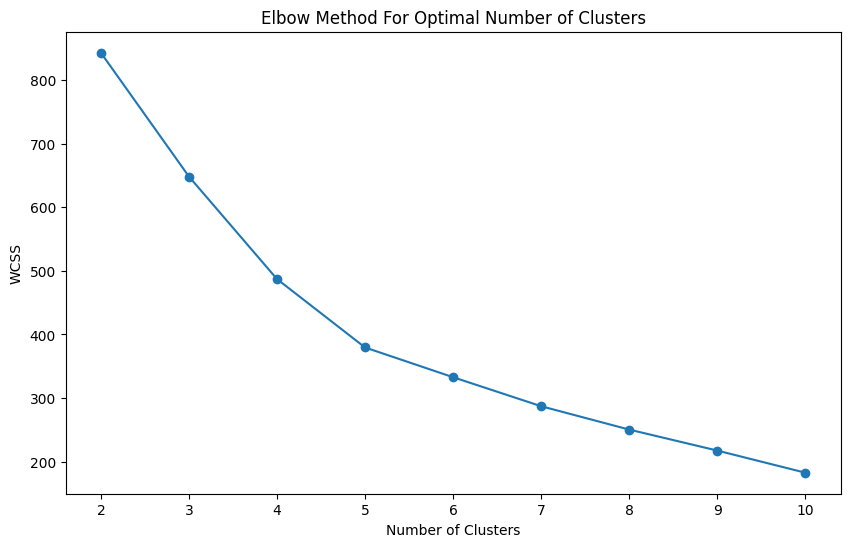

Davies-Bouldin Index: 0.9815298261120258
Silhouette Score: 0.37972387384442075


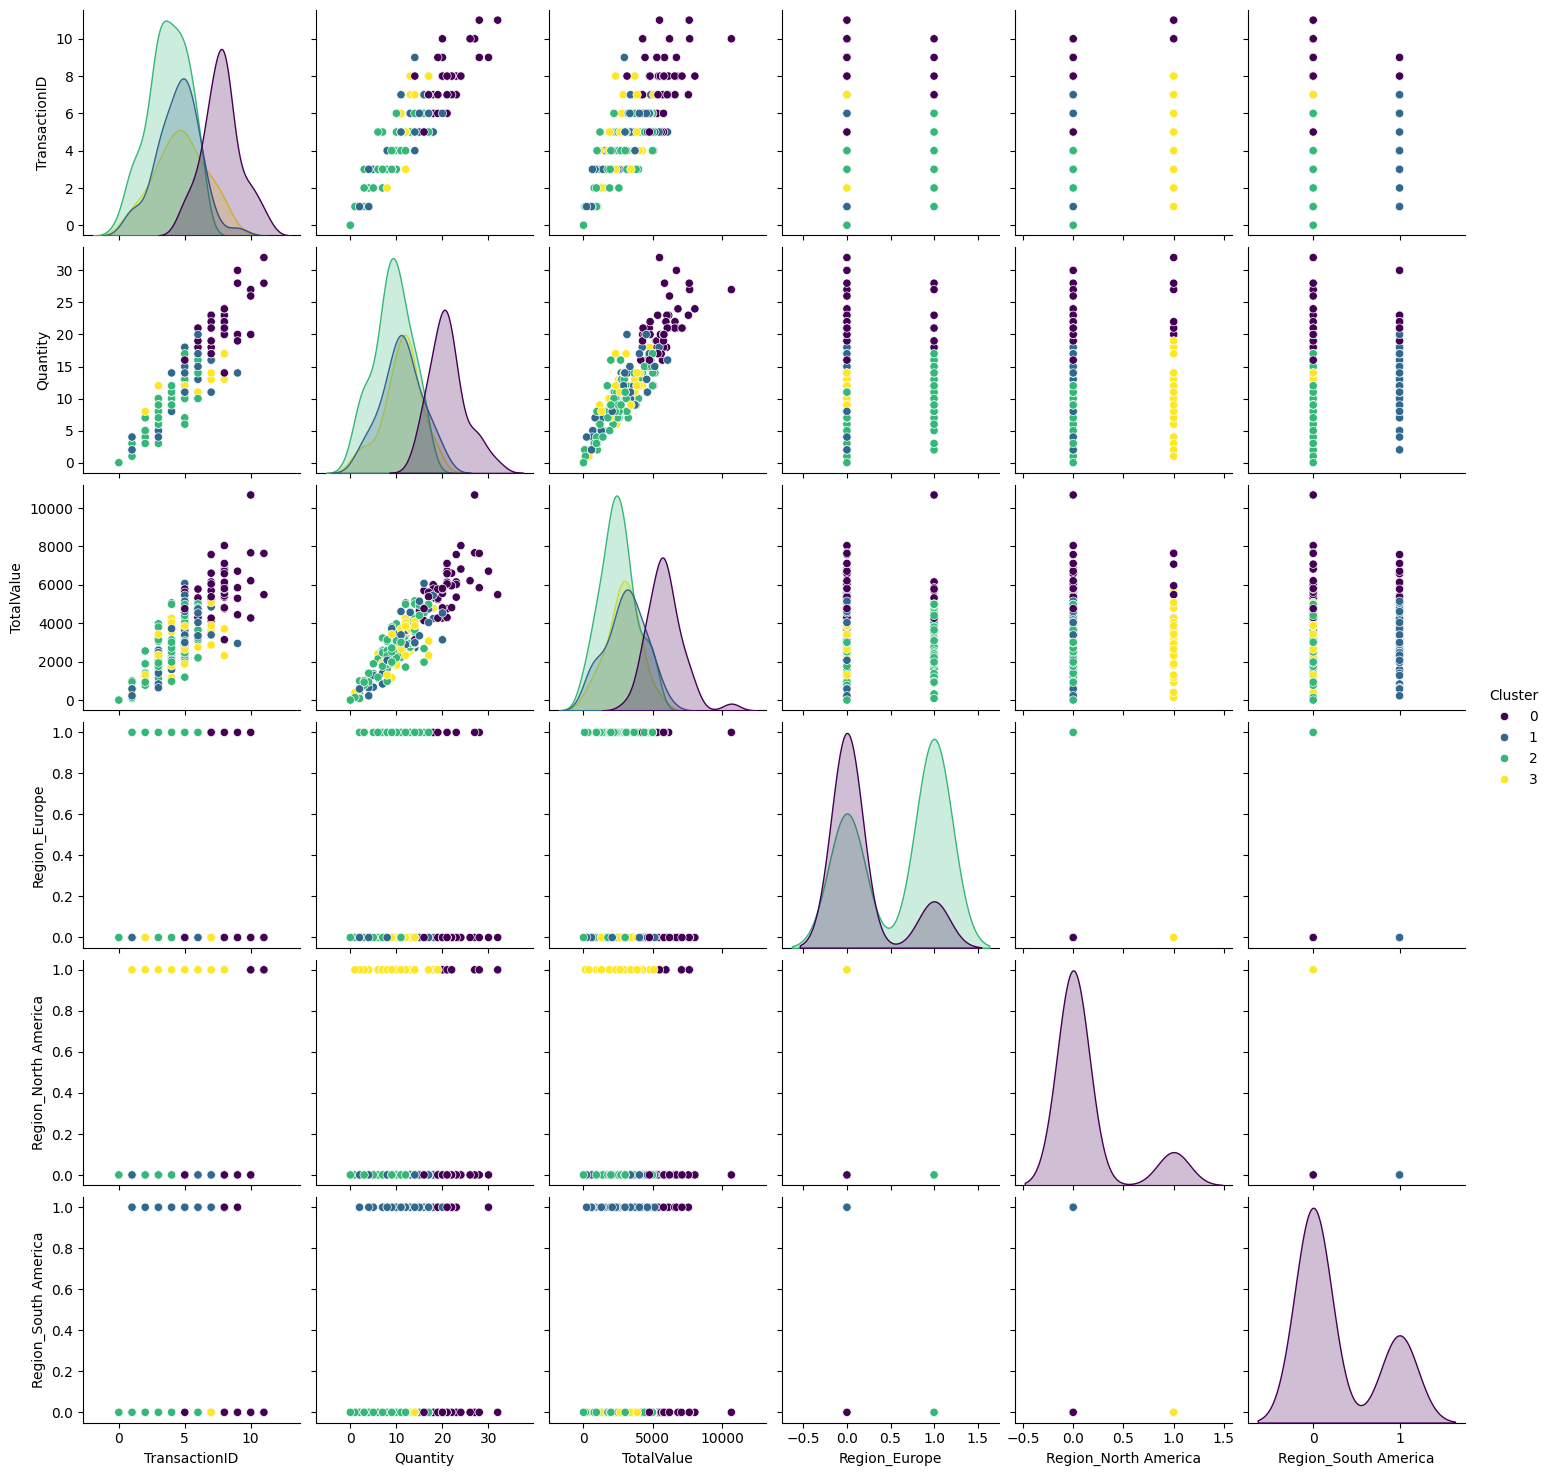

DBSCAN Davies-Bouldin Index: 1.4308838340126129
Agglomerative Davies-Bouldin Index: 1.0084583088342591


''

In [35]:


# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Data Preprocessing
# Convert dates to datetime
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Aggregate transaction data to create features for each customer
customer_transactions = transactions.groupby('CustomerID').agg({
    'TransactionID': 'count',
    'Quantity': 'sum',
    'TotalValue': 'sum'
}).reset_index()

# Merge customer and transaction data
customer_data = pd.merge(customers, customer_transactions, on='CustomerID', how='left')

# Fill missing values in transaction data with 0
customer_data.fillna({'TransactionID': 0, 'Quantity': 0, 'TotalValue': 0}, inplace=True)

# Encode categorical variables
customer_data = pd.get_dummies(customer_data, columns=['Region'], drop_first=True)

# Drop columns that won't be used for clustering
customer_data.drop(['CustomerID', 'CustomerName', 'SignupDate'], axis=1, inplace=True)

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data)

# Determine the optimal number of clusters using the elbow method
wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), wcss, marker='o')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# Perform clustering with the optimal number of clusters (let's assume it's 4)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Add cluster labels to the original data
customer_data['Cluster'] = clusters

# Calculate clustering metrics
db_index = davies_bouldin_score(scaled_data, clusters)
silhouette_avg = silhouette_score(scaled_data, clusters)
print(f'Davies-Bouldin Index: {db_index}')
print(f'Silhouette Score: {silhouette_avg}')

# Visualize the clusters
sns.pairplot(customer_data, hue='Cluster', palette='viridis')
plt.show()

# Additional clustering algorithms
# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_clusters = dbscan.fit_predict(scaled_data)
customer_data['DBSCAN_Cluster'] = dbscan_clusters

# Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=4)
agglo_clusters = agglo.fit_predict(scaled_data)
customer_data['Agglo_Cluster'] = agglo_clusters

# Calculate additional clustering metrics
dbscan_db_index = davies_bouldin_score(scaled_data, dbscan_clusters)
agglo_db_index = davies_bouldin_score(scaled_data, agglo_clusters)
print(f'DBSCAN Davies-Bouldin Index: {dbscan_db_index}')
print(f'Agglomerative Davies-Bouldin Index: {agglo_db_index}')

# Save the clustering results to a CSV file
customer_data.to_csv('FirstName_LastName_Clustering.csv', index=False)

# PDF report
from fpdf import FPDF

class PDF(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, 'Customer Segmentation Report', 0, 1, 'C')

    def chapter_title(self, title):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, title, 0, 1, 'L')
        self.ln(5)

    def chapter_body(self, body):
        self.set_font('Arial', '', 12)
        self.multi_cell(0, 10, body)
        self.ln()

pdf = PDF()
pdf.add_page()

pdf.chapter_title('Clustering Results')
pdf.chapter_body(f'Number of Clusters: 4\nDavies-Bouldin Index (KMeans): {db_index:.2f}\nSilhouette Score (KMeans): {silhouette_avg:.2f}')
pdf.chapter_body(f'Davies-Bouldin Index (DBSCAN): {dbscan_db_index:.2f}\nDavies-Bouldin Index (Agglomerative): {agglo_db_index:.2f}')

pdf.chapter_title('Cluster Descriptions')
for cluster in range(4):
    cluster_size = customer_data[customer_data['Cluster'] == cluster].shape[0]
    pdf.chapter_body(f'Cluster {cluster}: {cluster_size} customers')

pdf.output('Likhith_SV_Clustering.pdf')

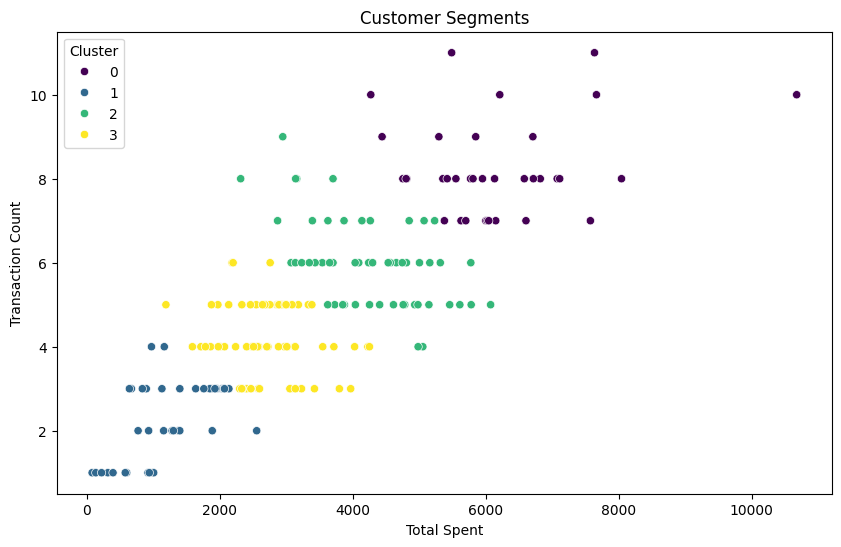

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TotalSpent', y='TransactionCount', hue='Cluster', data=customer_profile, palette='viridis')
plt.title('Customer Segments')
plt.xlabel('Total Spent')
plt.ylabel('Transaction Count')
plt.legend(title='Cluster')
plt.show()